In [3]:
%run part01_data_preparation.ipynb

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141736 entries, 0 to 141946
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           141736 non-null  object        
 1   is_canceled                     141736 non-null  int64         
 2   lead_time                       141736 non-null  int64         
 3   arrival_date_year               141736 non-null  int64         
 4   arrival_date_month              141736 non-null  object        
 5   arrival_date_week_number        141736 non-null  int64         
 6   arrival_date_day_of_month       141736 non-null  int64         
 7   stays_in_weekend_nights         141736 non-null  int64         
 8   stays_in_week_nights            141736 non-null  int64         
 9   adults                          141736 non-null  int64         
 10  children                        141736 non-null  int32  

In [94]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import time

### Machine Learning Libraries ###
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, FunctionTransformer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, VarianceThreshold, SelectPercentile
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

import sys

import joblib

sys.path.append("..")

In [95]:
data_prep = data.copy()
len(data_prep.columns)

36

In [96]:
data_prep.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_pp', 'people',
       'kids', 'days_stay'],
      dtype='object')

## Feature Engeenier

In [97]:
data_prep["country"] = [0 if i =='PRT' else 1 for i in data_prep["country"]] # native or foreigner
data_prep["previous_cancellations"] = [0 if i == 0 else 1 for i in data_prep["previous_cancellations"]] # not cancel once or cancel at least once
data_prep["company"] = [0 if i == 0 else 1 for i in data_prep["company"]] # do not have a Company or have a Company

meal_dct = {'Undefined':0,'BB':1,'HB':2,'FB':3,'SC':4}
data_prep["meal"] = [meal_dct[m] for m in data_prep["meal"]]

In [98]:
drop_numerical_features = ['is_canceled', # Target Feature
                           'arrival_date_year', 
                           'stays_in_weekend_nights','stays_in_week_nights', # Replaced by days_stay
                           'children', 'babies', # Replaced by kids
                           'previous_bookings_not_canceled',
                           'days_in_waiting_list', # low variance 
                           'adr_pp', # almost same meaning of adr
                           'previous_bookings_not_canceled',
                           'people'] # Same meaning of Adults + Kids 

numerical_df = data_prep.select_dtypes(include = ["number"]).drop(drop_numerical_features, axis=1)
numerical_features =  data_prep.select_dtypes(include=["number"]).drop(drop_numerical_features, axis=1).columns
numerical_list = numerical_features.tolist()

In [99]:
drop_categorical_features = ['arrival_date_month', # almost same meaning of arrival_date_week_number
                             'distribution_channel', # almost same meaning of market_segment
                             'deposit_type', # not predtive
                             'reservation_status', # not predtive
                             'reservation_status_date', # not predtive
                             'assigned_room_type'] # Almost always same of reserved_room_type

categorical_df = data_prep.select_dtypes(include = ['category','object','datetime']).drop(drop_categorical_features, axis=1)
categorical_features = data_prep.select_dtypes(include=["category","object","datetime"]).drop(drop_categorical_features, axis=1).columns
categorical_list=categorical_features.tolist()

## Normalization

In [100]:
log_columns = data_prep[numerical_list].skew().sort_values(ascending=False)
log_columns = log_columns.loc[(log_columns > 0.75)]
log_columns

adults                         24.749257
adr                             9.528857
booking_changes                 5.522578
is_repeated_guest               5.416710
kids                            4.420196
required_car_parking_spaces     4.100500
company                         3.818756
days_stay                       3.198430
previous_cancellations          3.173181
meal                            2.209273
total_of_special_requests       1.394436
lead_time                       1.317312
agent                           1.282939
dtype: float64

In [101]:
for col in log_columns.index:
    numerical_df[col] = np.log1p(numerical_df[col])

In [102]:
categorical_df=pd.get_dummies(data_prep[categorical_list])#,drop_first=True

In [103]:
xx = SelectPercentile(f_classif, percentile=80).fit_transform(numerical_df, y)

In [104]:
xxz = SelectPercentile(chi2, percentile=80).fit_transform(categorical_df,y)

In [105]:
len(xxz)

141736

In [106]:
x

SelectPercentile(percentile=80)

In [107]:
target = 'is_canceled'
selected_features = numerical_list + categorical_list

X = np.concatenate((xx, xxz),axis=1)

y = data_prep[target]
#X = pd.concat([numerical_df,categorical_df], axis=1)

In [108]:
seed=7
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=seed)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((99215, 30), (99215,), (42521, 30), (42521,))

In [109]:
def CM(y, y_pred):
    print("Confusion Matrix:")
    labels = ["Non-canceled", "Canceled"]
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")  
    plt.show() 
    print("Metrics \n", classification_report(y,y_pred))   

In [110]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [111]:
model = xgb.fit(X_train, y_train)
predictions = model.predict(X_val)
acc = accuracy_score(y_val, predictions)

print("acc:", acc)

acc: 0.8783659838667952


In [112]:
def CVS(model, X, y, model_dict=''):    
    
    number_folds = 3
    #Kfold = KFold(n_splits=number_folds, shuffle=True, random_state=seed)
    Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=seed)
    
    scoring = {'Accuracy': make_scorer(accuracy_score),
               'Precision': make_scorer(precision_score),
               'f1': make_scorer(f1_score),
               'Recall': make_scorer(recall_score)}    
    
    validation_score = pd.DataFrame(columns=['Method','Time','Accuracy','Precision','Recall','F1 Score'])

    y_pred = cross_val_predict(model, X, y, cv=Kfold, method='predict')
   
    CM(y,y_pred)
   
    scores = cross_validate(model, X, y, cv = Kfold, scoring=scoring)
    
    for chave, valor in scores.items():
        print(f"{chave}, over {number_folds} folds attempts: {round(np.mean(valor),5)} +/- {round(np.std(valor),5)}")      
  
    print("\n")
    n=25
    print(f"First {n} Predictions: {y_pred[0:n]}\nLast {n} Predictions: {y_pred[n:0:-1]} \n")   
    
    validation_score = (model_dict, 
                        (scores.get('fit_time').mean()+scores.get('score_time').mean()),
                        scores.get('test_Accuracy').mean(), 
                        scores.get('test_Precision').mean(),
                        scores.get('test_f1').mean(), 
                        scores.get('test_Recall').mean())  

    return y_pred, validation_score

In [113]:
models = [lr,xgb, rf]
model_dict = {0:'Logistic Regression', 1:'XGBoost', 2:'Random Forest'}

*****************************************************
Logistic Regression
*****************************************************
Confusion Matrix:


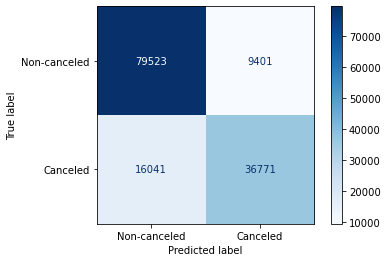

Metrics 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     88924
           1       0.80      0.70      0.74     52812

    accuracy                           0.82    141736
   macro avg       0.81      0.80      0.80    141736
weighted avg       0.82      0.82      0.82    141736

fit_time, over 3 folds attempts: 0.55404 +/- 0.00294
score_time, over 3 folds attempts: 0.02533 +/- 0.00047
test_Accuracy, over 3 folds attempts: 0.8205 +/- 0.00019
test_Precision, over 3 folds attempts: 0.7964 +/- 0.00147
test_f1, over 3 folds attempts: 0.74297 +/- 0.00079
test_Recall, over 3 folds attempts: 0.69626 +/- 0.00244


First 25 Predictions: [1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1] 

*****************************************************
XGBoost
*****************************************************
Confusion Matrix:


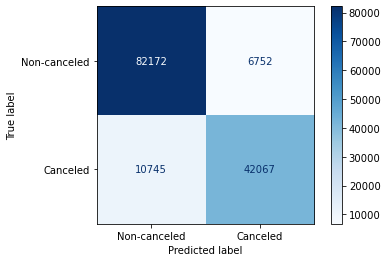

Metrics 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     88924
           1       0.86      0.80      0.83     52812

    accuracy                           0.88    141736
   macro avg       0.87      0.86      0.87    141736
weighted avg       0.88      0.88      0.88    141736

fit_time, over 3 folds attempts: 1.61345 +/- 0.02389
score_time, over 3 folds attempts: 0.059 +/- 0.00082
test_Accuracy, over 3 folds attempts: 0.87655 +/- 0.00077
test_Precision, over 3 folds attempts: 0.8617 +/- 0.00221
test_f1, over 3 folds attempts: 0.82784 +/- 0.00116
test_Recall, over 3 folds attempts: 0.79654 +/- 0.00268


First 25 Predictions: [1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1] 

*****************************************************
Random Forest
*****************************************************
Confusion Matrix:


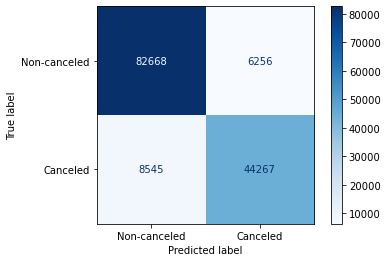

Metrics 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     88924
           1       0.88      0.84      0.86     52812

    accuracy                           0.90    141736
   macro avg       0.89      0.88      0.89    141736
weighted avg       0.90      0.90      0.90    141736

fit_time, over 3 folds attempts: 6.14324 +/- 0.07292
score_time, over 3 folds attempts: 0.60948 +/- 0.01356
test_Accuracy, over 3 folds attempts: 0.8953 +/- 0.00044
test_Precision, over 3 folds attempts: 0.8759 +/- 0.00235
test_f1, over 3 folds attempts: 0.85637 +/- 0.00076
test_Recall, over 3 folds attempts: 0.83771 +/- 0.00301


First 25 Predictions: [1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0]
Last 25 Predictions: [1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0] 

Wall time: 54.4 s


In [114]:
%%time

validation_score = pd.DataFrame(columns=['Method','Time','Accuracy','Precision','Recall','F1 Score'])

for i,model in enumerate(models): 
    print('*' * 53) 
    print(f"{model_dict[i]}") 
    print('*' * 53)     
    y_pred , validation_score.loc[i]  = CVS(model,X,y,model_dict[i])   

*****************************************************
Machine Learning algorithm: Logistic Regression
*****************************************************


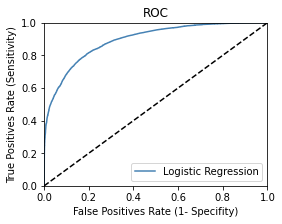

AUC Logistic Regression: 0.8936


*****************************************************
Machine Learning algorithm: XGBoost
*****************************************************


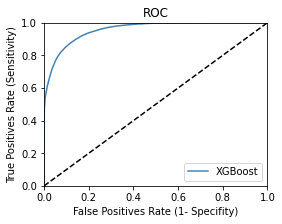

AUC XGBoost: 0.9572


*****************************************************
Machine Learning algorithm: Random Forest
*****************************************************


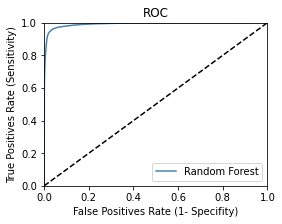

AUC Random Forest: 0.9916




In [115]:
score_metrics_auc = pd.DataFrame(columns=['Model','AUC'])

for i,model in enumerate(models): 
    print('*' * 53) 
    print(f"Machine Learning algorithm: {model_dict[i]}") 
    print('*' * 53)   
    y_prob = model.fit(X_train,y_train)
    y_prob = model.predict_proba(X)
    y_prob = y_prob[:,1]
    
    fpr,tpr, threshold = roc_curve(y,y_prob)
    auc = roc_auc_score(y,y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr,tpr, color='steelblue', label = model_dict[i])    
    plt.title("ROC")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.xlabel("False Positives Rate (1- Specifity)")
    plt.ylabel("True Positives Rate (Sensitivity)")
    plt.legend(loc = 'lower right') 
    plt.show()
    print(f"AUC {model_dict[i]}: {auc:.4f}\n\n") 
    
    score_metrics_auc.loc[i]=[model_dict[i], auc]

In [116]:
validation_score['AUC'] = score_metrics_auc['AUC']
validation_score

,Method,Time,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.579374,0.820497,0.796399,0.742967,0.696262,0.893635
1,XGBoost,1.672452,0.876552,0.861703,0.827837,0.796542,0.957172
2,Random Forest,6.752724,0.895298,0.875900,0.856370,0.837707,0.991574


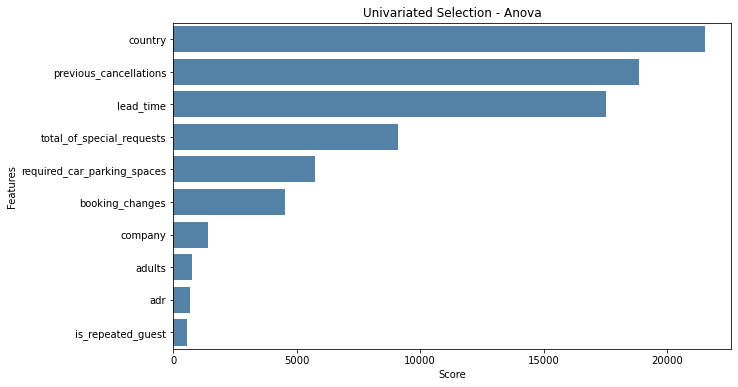

In [117]:
### Apply SelectKBest Algorithm - Anova
anova = SelectKBest(score_func=f_classif, k=10).fit(numerical_df,y)
anova_scores=pd.DataFrame(anova.scores_,columns=["Score"])
anova_columns=pd.DataFrame(numerical_df.columns)
anova_feature_rank=pd.concat([anova_columns,anova_scores],axis=1)
anova_feature_rank.columns=['Features','Score']
anova_feature_rank=anova_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Anova')
sns.barplot(data=anova_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

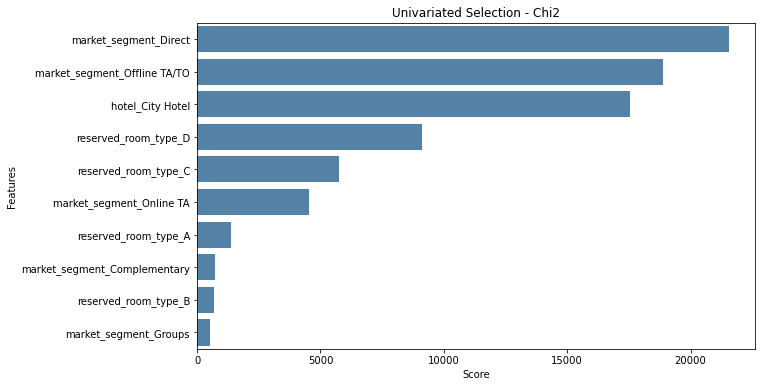

In [118]:
### Apply SelectKBest Algorithm - Chi2
chi2 = SelectKBest(score_func=chi2, k=10).fit(categorical_df,y)
chi2_scores=pd.DataFrame(chi2.scores_,columns=["Score"])
chi2_columns=pd.DataFrame(categorical_df.columns)
chi2_feature_rank=pd.concat([chi2_columns,anova_scores],axis=1)
chi2_feature_rank.columns=['Features','Score']
chi2_feature_rank=chi2_feature_rank.nlargest(10,'Score')

plt.figure(figsize=(10,6))
plt.title('Univariated Selection - Chi2')
sns.barplot(data=chi2_feature_rank, x='Score', y='Features', color='SteelBlue');
plt.show()

In [119]:
#rf = RandomForestClassifier(class_weight={0: 1, 1: weight}, random_state=seed)
rf.fit(X_train,y_train)

fi_rf = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.title('Feature Importance - Random Forest Regressor')
sns.barplot(data=fi_rf.head(15), x='Importance', y='Features', color='SteelBlue');
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [120]:
#xgb = XGBClassifier(scale_pos_weight=weight, random_state=seed)
xgb.fit(X_train,y_train)

fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance - XGBoost Regressor')
sns.barplot(data=fi_xgb.head(15), x='importance', y='feature', color='SteelBlue');
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Confusion Matrix:


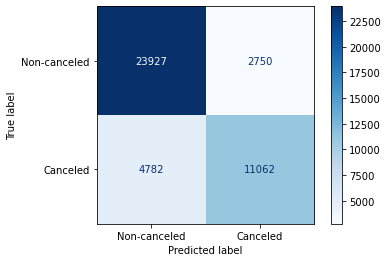

Metrics 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86     26677
           1       0.80      0.70      0.75     15844

    accuracy                           0.82     42521
   macro avg       0.82      0.80      0.81     42521
weighted avg       0.82      0.82      0.82     42521


Accuracy Score Traning:0.819110011233497, Accuracy Score Validation:0.8228639966134381

Best Paramters:
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Best Estimator:
LogisticRegression(C=10)
Wall time: 47.4 s


In [122]:
%%time
### Tunning parameters: Logistic Regression ###

np.random.seed(7)

params_lr = { 
        #'preprocessor__num__std' : [MinMaxScaler(), RobustScaler()],
        #'selection': [SelectPercentile(f_classif, percentile=50), SelectPercentile(f_classif, percentile=80), SelectPercentile(f_classif, percentile=95)],
        'C': [0.1,1,10], 
        'solver': ['lbfgs','saga'], 
        'penalty': ['l1','l2'],
        
}

gs = GridSearchCV(estimator=lr, param_grid=params_lr, cv=3, scoring="accuracy", verbose=True, return_train_score=False)
gs.fit(X_train,y_train)


lr_tuned_best_score = gs.best_score_
lr_tuned_best_params = gs.best_params_
lr_tuned_best_estimator = gs.best_estimator_
y_pred_lr_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_lr_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Confusion Matrix:


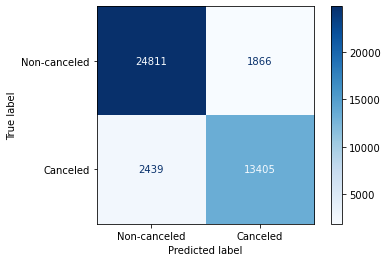

Metrics 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     26677
           1       0.88      0.85      0.86     15844

    accuracy                           0.90     42521
   macro avg       0.89      0.89      0.89     42521
weighted avg       0.90      0.90      0.90     42521


Accuracy Score Traning:0.8881318225889127, Accuracy Score Validation:0.8987559088450413

Best Paramters:
{'learning_rate': 0.05, 'max_depth': 18, 'n_estimators': 600}

Best Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=18, max_leaves=0, mi

In [124]:
%%time
### Tunning parameters: XGBoost

np.random.seed(7)

params_xgb = { 
        #'preprocessor__num__std' : [MinMaxScaler(), RobustScaler()],
        #'selection': [SelectPercentile(f_classif, percentile=80)],
        'max_depth': [18,24,30],
        'learning_rate': [0.05,0.10], 
        #'classifier__min_child_weight': [1,3],
        'n_estimators': [100, 300, 600],    
        #'eta' : [0.1, 0.3]
            }

gs = GridSearchCV(estimator=xgb, param_grid=params_xgb, cv=3, scoring="accuracy", n_jobs=2, verbose=True, return_train_score=False)
gs.fit(X_train,y_train)


xgb_tuned_best_score = gs.best_score_
xgb_tuned_best_params = gs.best_params_
xgb_tuned_best_estimator = gs.best_estimator_
y_pred_xgb_tuned = gs.best_estimator_.predict(X_val)
validation_score = gs.score(X_val, y_val)

CM(y_val, y_pred_xgb_tuned)

print(f"\nAccuracy Score Traning:{gs.best_score_}, Accuracy Score Validation:{validation_score}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 